<a href="https://colab.research.google.com/github/morreh89/Loan-Default-Prediction/blob/master/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.0 Description of the challenge:**

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.

1) willingness to pay and

2) ability to pay. 

Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.
These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.

**1.1 Problem**

The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. 


**1.2 Description of the data**

There are 3 different datasets for both train and test

**1.2.1 Demographic data (traindemographics.csv)**

- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not -  compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)



**1.2.2 Performance data (trainperf.csv)** 

This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict


**1.2.3 Previous loans data (trainprevloans.csv) **

This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)




In [1]:
import pandas as pd                             #import pandas for dataframe manipulation
import numpy as np                              #import numerical python
import seaborn as sns                           #seaborn for visuals
import matplotlib as mpl                        #matplot for plotting
import matplotlib.pyplot as plt                 #matplot for plotting
import itertools
import datetime as dt                           #convert date formats
from scipy import stats  


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pip install pandas-profiling==2.8.0


2. Load The Data 


In [3]:
#Read datasets
traindemographics = pd.read_csv('traindemographics.csv', parse_dates=['birthdate'])
testdemographics = pd.read_csv('testdemographics.csv', parse_dates=['birthdate'])
trainperf = pd.read_csv('trainperf.csv', parse_dates=['approveddate','creationdate'])
testperf = pd.read_csv('testperf.csv',parse_dates=['approveddate','creationdate'])
trainprevloans= pd.read_csv('trainprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                           'firstduedate','firstrepaiddate'])
testprevloans = pd.read_csv('testprevloans.csv', parse_dates=['approveddate','creationdate','closeddate',
                                                                          'firstduedate','firstrepaiddate'])

2.2 Checking The Shapes of data loaded

In [4]:
# Check The Shapes
print('Test Demographic shape: {} Rows, {} Columns'.format(*trainperf.shape))
print('Test Performance shape: {} Rows, {} Columns'.format(*traindemographics.shape))
print('Test Previous Loan shape: {} Rows, {} Columns'.format(*trainprevloans.shape))
print('Train Demographic shape: {} Rows, {} Columns'.format(*testperf.shape))
print('Train Performance shape: {} Rows, {} Columns'.format(*testdemographics.shape))
print('Train Previous Loan shape: {} Rows, {} Columns'.format(*testprevloans.shape))

Test Demographic shape: 4368 Rows, 10 Columns
Test Performance shape: 4346 Rows, 9 Columns
Test Previous Loan shape: 18183 Rows, 12 Columns
Train Demographic shape: 1450 Rows, 9 Columns
Train Performance shape: 1487 Rows, 9 Columns
Train Previous Loan shape: 5907 Rows, 12 Columns


2.3 Checking the rows

In [5]:
# Print First Three Rows Of The Data loaded
display("test demographics")
display(testdemographics.head(3))
display("test performance")
display(testperf.head(3))
display("test previous loans")
display(testprevloans.head(3))
display("train demographics")
display(traindemographics.head(3))
display("train performance")
display(trainperf.head(3))
display("train previous loans")
display(trainprevloans.head(3))

'test demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28,Savings,5.296628,7.593965,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23,Savings,3.294513,6.596602,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04,Savings,8.501912,7.729364,First Bank,NaN,Permanent,NaN


'test performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN


'test previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00,2016-05-17 09:36:55,10000.0,13000.0,30,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59,2017-02-04 20:28:52,30000.0,36800.0,60,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22,2017-03-04 09:28:16,30000.0,34400.0,30,2017-04-02 00:44:24,NaN,2017-04-03,2017-04-01 21:29:46


'train demographics'

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN


'train performance'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,Good


'train previous loans'

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47



**3 Data Exploration**

3.1.1 Column/Variable Names


In [6]:

display("test demographics")
display(testdemographics.columns)
display("test performance")
display(testperf.columns)
display("test previous loans")
display(testprevloans.columns)
display("train demographics")
display(traindemographics.columns)
display("train performance")
display(trainperf.columns)
display("train previous loans")
display(trainprevloans.columns)

'test demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'test performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby'],
      dtype='object')

'test previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

'train demographics'

Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')

'train performance'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')

'train previous loans'

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')

Now look at the number of columns of each data type

In [7]:
# Number of each type of column
display("test demographics")
display(testdemographics.dtypes.value_counts())
display("test performance")
display(testperf.dtypes.value_counts())
display("test previous loans")
display(testprevloans.dtypes.value_counts())
display("train demographics")
display(traindemographics.dtypes.value_counts())
display("train performance")
display(trainperf.dtypes.value_counts())
display("train previous loans")
display(trainprevloans.dtypes.value_counts())

'test demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'test performance'

object     4
int64      4
float64    1
dtype: int64

'test previous loans'

datetime64[ns]    5
int64             3
float64           2
object            2
dtype: int64

'train demographics'

object            6
float64           2
datetime64[ns]    1
dtype: int64

'train performance'

object            3
int64             3
datetime64[ns]    2
float64           2
dtype: int64

'train previous loans'

datetime64[ns]    5
int64             3
float64           2
object            2
dtype: int64

**Data Preparation**

**Merging the datasets**

tag the data with a set column specifying whether its from train or test set

In [8]:

traindemographics['set'] = 'train'
testdemographics['set'] = 'test'
trainperf['set'] = 'train'
testperf['set'] = 'test'
trainprevloans['set'] = 'train'
testprevloans['set'] = 'test'

In [9]:
Tdemographics=pd.concat([traindemographics,testdemographics])
Tperfomance=pd.concat([trainperf,testperf])
Tprevious=pd.concat([trainprevloans,testprevloans])

In [10]:
# Convert the good_bad_flag into numerical binary variable 
goodbad={'Good':1,'Bad':0}
Tperfomance.good_bad_flag=Tperfomance.good_bad_flag.map(goodbad)

In [11]:
Tperfomance.head()


,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,1.0,train
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,1.0,train
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,1.0,train
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,1.0,train
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,1.0,train


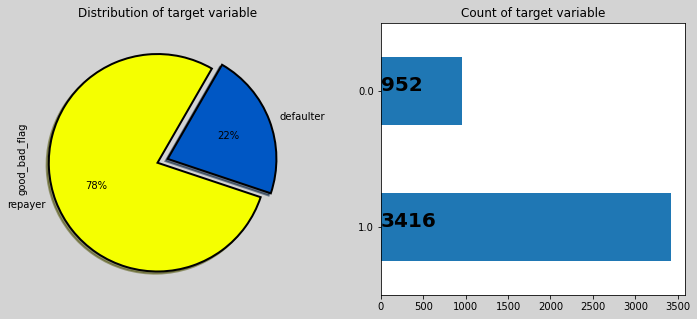

In [12]:
# Distribution of the target variable
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),
                                                                             startangle = 60,
                                            labels=["repayer","defaulter"],wedgeprops={"linewidth":2,"edgecolor":"k"},
                                            explode=[.1,0],shadow =True)
plt.title("Distribution of target variable")

plt.subplot(122)
ax = Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().plot(kind="barh")

for i,j in enumerate(Tperfomance[Tperfomance['set'] == "train"]["good_bad_flag"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of target variable")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

Checking for missing values in the performance train and test data

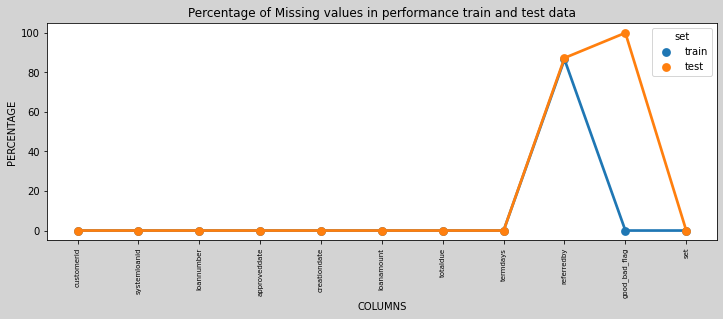

In [14]:

fig = plt.figure(figsize=(12,4))
miss_train = pd.DataFrame((Tperfomance[Tperfomance['set'] == "train"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "train"].shape[0]).reset_index()
miss_test  = pd.DataFrame((Tperfomance[Tperfomance['set'] == "test"].isnull().sum())*100/Tperfomance[Tperfomance['set'] == "test"].shape[0]).reset_index()
miss_train["set"] = "train"
miss_test["set"]  =  "test"
missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing,hue="set")
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in performance train and test data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

Checking the percentage of missing values in the rest of the datasets

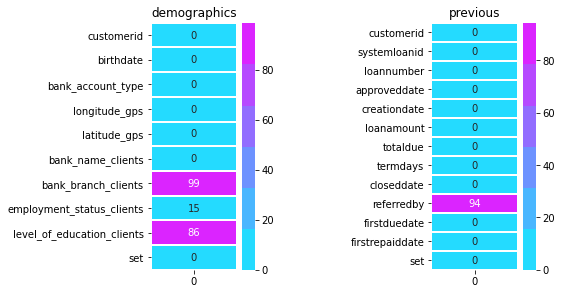

In [15]:
plt.figure(figsize=(12,10))

plt.subplot(231)
sns.heatmap(pd.DataFrame(Tdemographics.isnull().sum()/Tdemographics.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("demographics")

plt.subplot(232)
sns.heatmap(pd.DataFrame(Tprevious.isnull().sum()/Tprevious.shape[0]*100),annot=True,
            cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
plt.title("previous")

plt.subplots_adjust(wspace = 1.6)